# Using Chronicling America to analyze word frequency and geographic usage
Feel free to download this notebook and put in your own search queries.

## Notebook Example

For this example, we will look at the term "**influenza**" and its occurence in the U.S. newspapers in Chronicling America during **1800** and **1830**.

Specifically, we want to utilize the API to look at the word usage in relationship to time and location:
1. Time: When was the term published in newspapers?
2. Location: Where was the term most commonly used based on a newspaper's publication location?

## Importing Modules [Required]
The following imports are required for the scripts to run properly:

---
1. Run the following code below.
    * It will import all the modules you need for this notebook.
    * Do not change anything.

In [1]:
import time
import re
import json
from urllib.request import urlopen
import requests
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import pprint

# Perform a Query


In [2]:
# Perform Query - Paste your API Search Query URL into the searchURL.  It should have &fo=json at the end of the URL.
searchURL = 'https://www.loc.gov/collections/chronicling-america/?dl=page&end_date=1830-12-31&ops=AND&qs=influenza&searchType=advanced&start_date=1800-01-01&fo=json'


## Run Function
Functions and limits define what will be included and excluded in the search for downloads.
The code below will use the above query and gather the list of records associated with the search results. 

---
1. Run the code below.
    * Do not change anything.
    * Be patient and mindful when creating queries to run. Queries with more search results will take longer to process.
2. When the script is complete, it will tell you how many Newspaper Pages it found from your search.
3. If you are satisfied with the amount of results, proceed to the next section to run the metadata download.
4. If you are not satisfied with the amount of results, go back and redo the API Search Query.

In [3]:
def get_item_ids(url, items=[], conditional='True'):
    # Check that the query URL is not an item or resource link.
    exclude = ["loc.gov/item","loc.gov/resource"]
    if any(string in url for string in exclude):
        raise NameError('Your URL points directly to an item or '
                        'resource page (you can tell because "item" '
                        'or "resource" is in the URL). Please use '
                        'a search URL instead. For example, instead '
                        'of \"https://www.loc.gov/item/2009581123/\", '
                        'try \"https://www.loc.gov/maps/?q=2009581123\". ')

    # request pages of 100 results at a time
    params = {"fo": "json", "c": 100, "at": "results,pagination"}
    call = requests.get(url, params=params)
    # Check that the API request was successful
    if (call.status_code==200) & ('json' in call.headers.get('content-type')):
        data = call.json()
        results = data['results']
        for result in results:
            # Filter out anything that's a colletion or web page
            filter_out = ("collection" in result.get("original_format")) \
                    or ("web page" in result.get("original_format")) \
                    or (eval(conditional)==False)
            if not filter_out:
                # Get the link to the item record
                if result.get("id"):
                    item = result.get("id")
                    # Filter out links to Catalog or other platforms
                    if item.startswith("http://www.loc.gov/resource"):
                      resource = item  # Assign item to resource
                      items.append(resource)
                    if item.startswith("http://www.loc.gov/item"):
                        items.append(item)
        # Repeat the loop on the next page, unless we're on the last page.
        if data["pagination"]["next"] is not None:
            next_url = data["pagination"]["next"]
            get_item_ids(next_url, items, conditional)

        return items
    else:
            print('There was a problem. Try running the cell again, or check your searchURL.')

# Generate a list of records found from performing a query and save these Item IDs. (Create ids_list based on items found in the searchURL result)
ids_list = get_item_ids(searchURL, items=[])

# Add 'fo=json' to the end of each row in ids_list (All individual ids from from the ids_list are now listed in JSON format in new_ids)
ids_list_json = []
for id in ids_list:
  if not id.endswith('&fo=json'):
    id += '&fo=json'
  ids_list_json.append(id)
ids = ids_list_json

print('\nSuccess. Your API Search Query found '+str(len(ids_list_json))+' related newspaper pages.')


Success. Your API Search Query found 256 related newspaper pages.


## Get Basic Metadata/Information for your Query and Store It in a List

The script below will pull the metadata from your search query in preparation for download into a CSV. The JSON parameters in the script can be changed per your requirements. 

---
1. Run the code below.
    * Do not change anything.
    * Be patient and mindful when creating queries to run. Queries with more search results will take longer to process.
2. When the script is complete, a preview will be shown on the bottom.

In [4]:
# Create a list of dictionaries to store the item metadata
item_metadata_list = []

# Iterate over the list of item IDs
for item_id in ids_list_json:
  item_response = requests.get(item_id)

  # Check if the API call was successful and Parse the JSON response
  if item_response.status_code == 200:
    # Iterate over the ids_list_json list and extract the relevant metadata from each dictionary.
    item_data = item_response.json()
    if 'location_city' not in item_data['item']:
      continue

    # Extract the relevant item metadata
    Newspaper_Title = item_data['item']['newspaper_title']
    Issue_Date = item_data['item']['date']
    Page = item_data['pagination']['current']
    State = item_data['item']['location_state']
    City = item_data['item']['location_city']
    LCCN = item_data['item']['number_lccn']
    Contributor = item_data['item']['contributor_names']
    Batch = item_data['item']['batch']
    pdf = item_data['resource']['pdf']

    # Add the item metadata to the list
    item_metadata_list.append({
        'Newspaper Title': Newspaper_Title,
        'Issue Date': Issue_Date,
        'Page Number': Page,
        'LCCN': LCCN,
        'City': City,
        'State': State,
        'Contributor': Contributor,
        'Batch': Batch,
        'PDF Link': pdf,
  })

# Change date format to MM-DD-YYYY
for item in item_metadata_list:
  item['Issue Date'] = pd.to_datetime(item['Issue Date']).strftime('%m-%d-%Y')

# Create a Pandas DataFrame from the list of dictionaries
df = pd.DataFrame(item_metadata_list)

print('\nReady to proceed to the next step!')


Ready to proceed to the next step!


# Export Metadata of Search Results to a CSV File

---
1. Edit your save location and the filename below.
2. Then run the code.

In [5]:
# Add your Local saveTo Location (e.g. C:/Downloads/)
saveTo = 'output'

# Set File Name. Make sure to rename the file so it doesn't overwrite previous!
filename = 'MetadataFileName'

Press Run to save your file and print out a dataframe preview example below:



In [6]:
print('\nSuccess! Please check your saveTo location to see the saved csv file. See Preview Below:\n')

metadata_dataframe = pd.DataFrame(item_metadata_list)
metadata_dataframe.to_csv(saveTo + '/' + filename + '.csv')
metadata_dataframe


Success! Please check your saveTo location to see the saved csv file. See Preview Below:



,Newspaper Title,Issue Date,Page Number,LCCN,City,State,Contributor,Batch,PDF Link
0,[Virginia Argus],09-09-1807,1,[sn84024710],[richmond],[virginia],"[Library of Virginia; Richmond, VA]",[vi_otters_ver02],https://tile.loc.gov/storage-services/service/...
1,"[The Wilmingtonian, and Delaware advertiser]",04-20-1826,1,[sn85042523],[wilmington],[delaware],"[University of Delaware Library, Newark, DE]",[deu_kedavra_ver01],https://tile.loc.gov/storage-services/service/...
2,"[Alexandria gazette, commercial and political]",11-15-1815,2,[sn84024014],[alexandria],[virginia],"[Library of Virginia; Richmond, VA]",[vi_greenjackets_ver02],https://tile.loc.gov/storage-services/service/...
3,[Virginia advocate],06-11-1830,3,[sn84024689],[charlottesville],[virginia],"[Library of Virginia; Richmond, VA]",[vi_naturals_ver01],https://tile.loc.gov/storage-services/service/...
4,"[Northern star, and Warren and Bristol gazette]",03-11-1826,3,[sn83021518],[warren],[rhode island],[Rhode Island Digital Newspaper Project],[rp_azer_ver02],https://tile.loc.gov/storage-services/service/...
...,...,...,...,...,...,...,...,...,...
244,"[The Massachusetts spy, and Worcester County a...",04-09-1828,4,[sn83021206],[worcester],[massachusetts],[Boston Public LIbrary],[mb_circe_ver01],https://tile.loc.gov/storage-services/service/...
245,[Richmond enquirer],06-09-1826,3,[sn84024735],[richmond],[virginia],"[Library of Virginia; Richmond, VA]",[vi_naturals_ver01],https://tile.loc.gov/storage-services/service/...
246,[Richmond enquirer],06-09-1826,4,[sn84024735],[richmond],[virginia],"[Library of Virginia; Richmond, VA]",[vi_naturals_ver01],https://tile.loc.gov/storage-services/service/...
247,[Richmond enquirer],10-02-1821,3,[sn84024735],[richmond],[virginia],"[Library of Virginia; Richmond, VA]",[vi_mudhens_ver02],https://tile.loc.gov/storage-services/service/...


## Apply Visualizations to your Data Table


Now that you have your saved data file, we recommend cleaning the data before applying it onto visualization applications like Tableau, Microsoft Excel, etc.



---



Below are examples created by the data we gathered from our search.





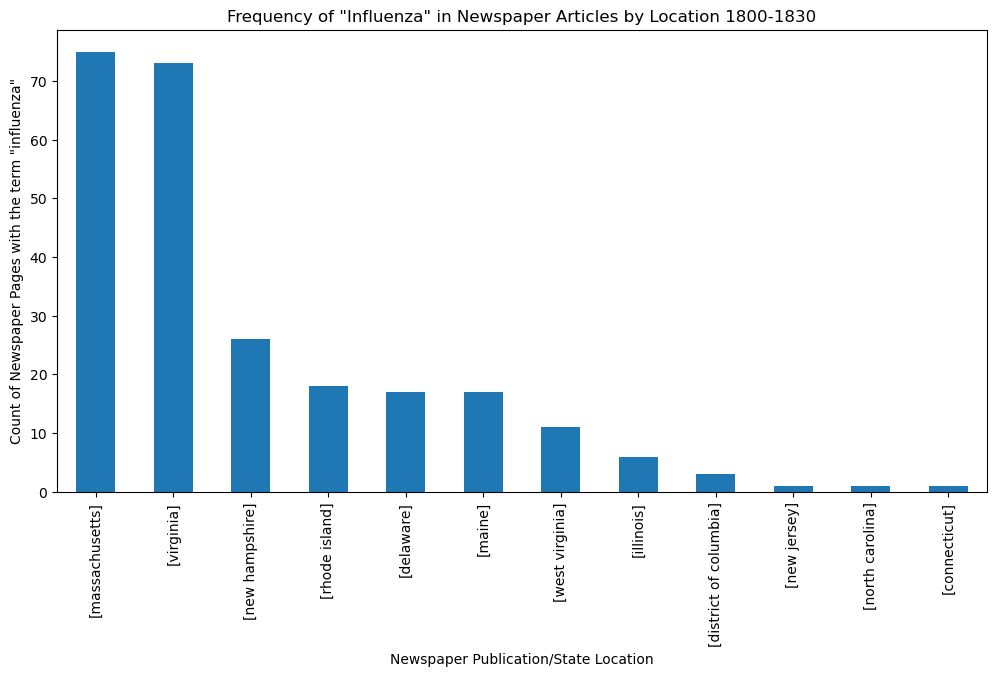

In [7]:
# Create a Visualization to show which State newspapers used the Term 

# Create a bar chart of the state counts
plt.figure(figsize=(12,6))
df['State'].value_counts().plot.bar()
plt.xlabel('Newspaper Publication/State Location')
plt.ylabel('Count of Newspaper Pages with the term "influenza"')
plt.title('Frequency of "Influenza" in Newspaper Articles by Location 1800-1830')
plt.show()
